# Decorrelation test of image noise

DM-24371 introduces a unit test case of noise decorrelation of a sourceless image based on the section "Estimate the correlation directly in the image" below. The "Autocorrelation if Fourier space" section is for demonstration of the same concept in frequency space only.

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Import the unit test code to use image generator code from there
verbose = True

# Re-running this run statement does not always update the definition of the class/functions in the notebook
# Development version copy here of unit test in lsst/ip_diffim/tests/test_imageDecorrelation.py
%run -n -i "test_decorr_afterburner.py"

In [3]:
T = DiffimCorrectionTest()
T.setUp()
# Make the difference image correlated (matched template) noise dominated,
# otherwise the effect to correct for is minimal
svar = 1.
tvar = 100. 
T._setUpSourcelessImages(svar=svar, tvar=tvar)

Let's see the images.

<IPython.core.display.Javascript object>


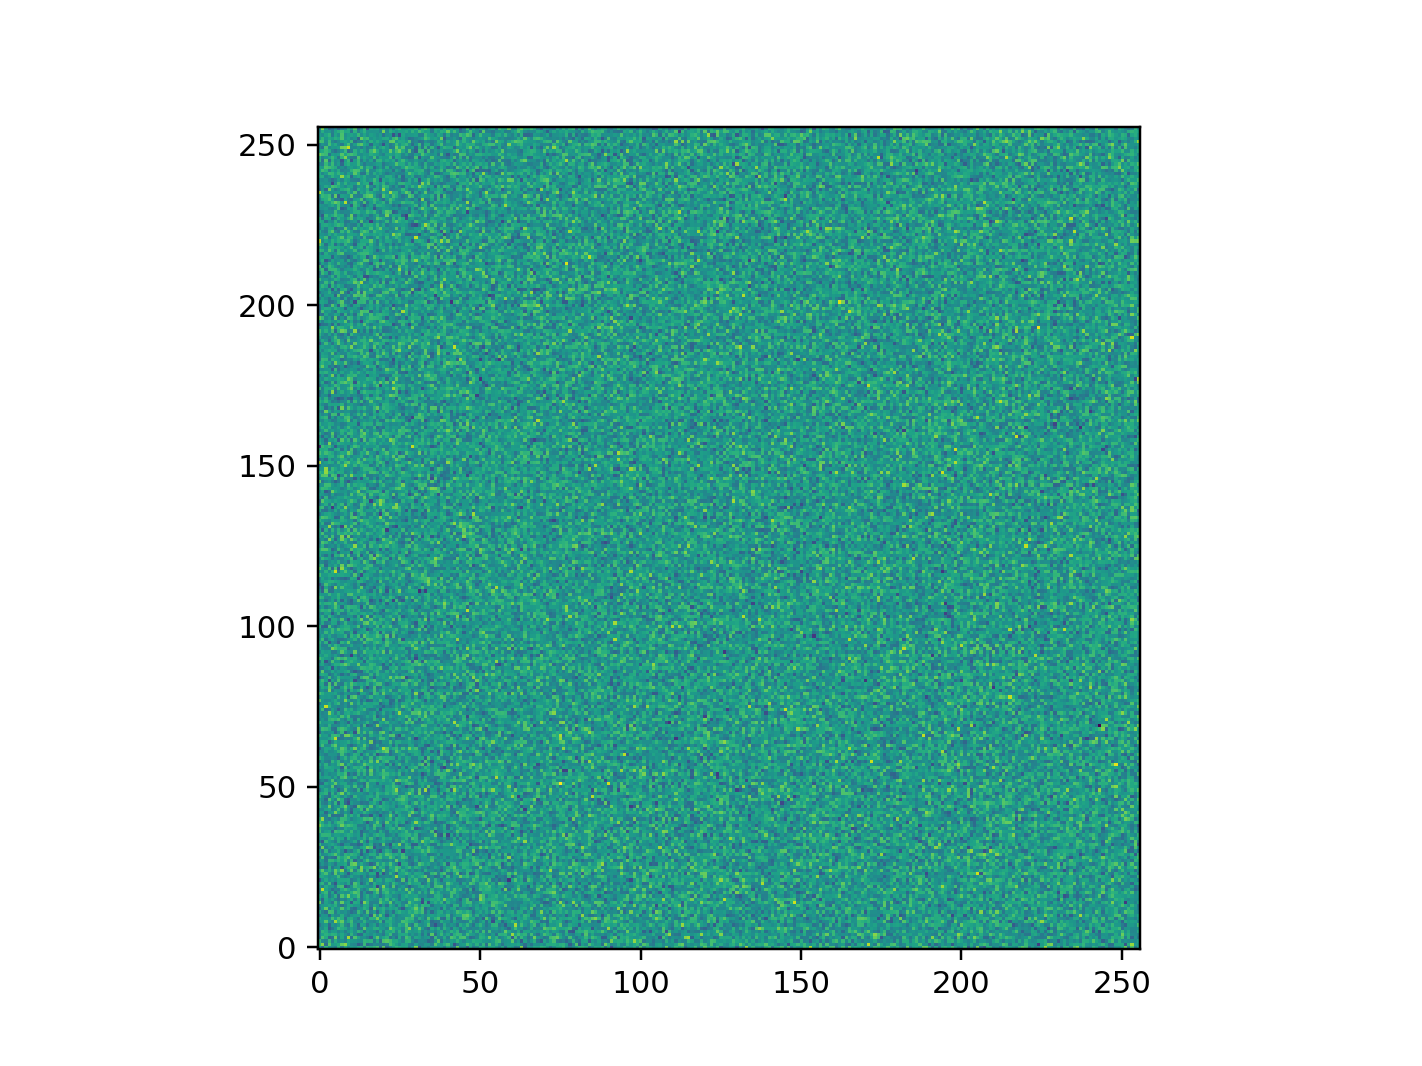

<IPython.core.display.Javascript object>


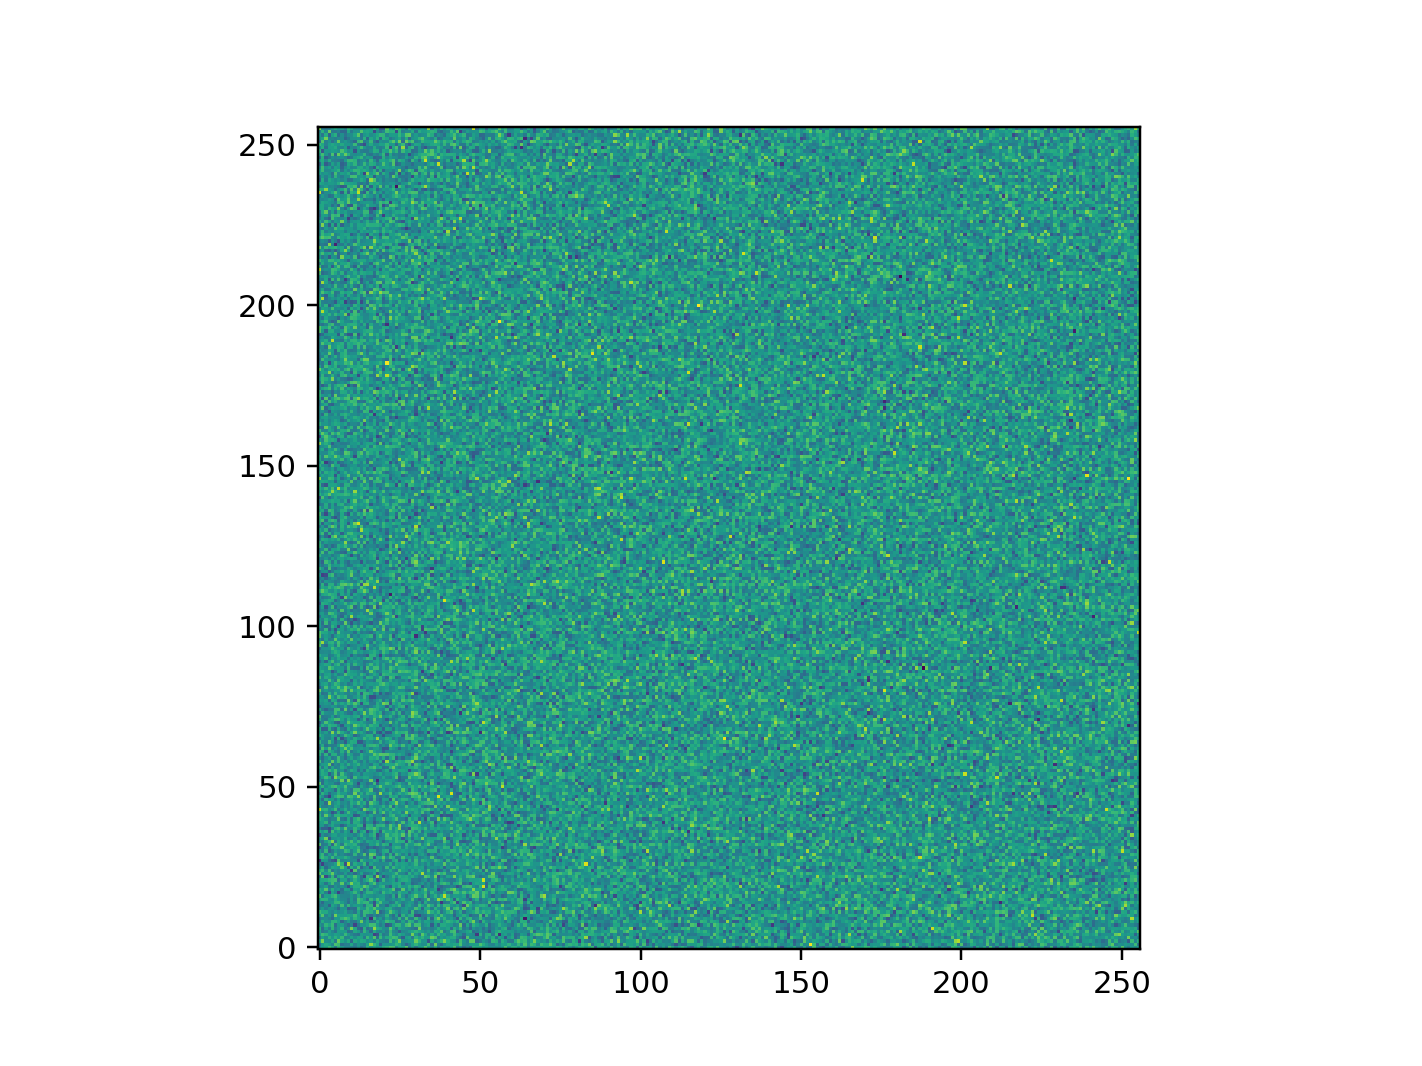

In [4]:
imS = T.im1ex.getImage()
imT = T.im2ex.getImage()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(imS.getArray(), interpolation='none', origin='bottom')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(imT.getArray(), interpolation='none', origin='bottom')

Let's create the difference image and perform the initial sanity checks.

In [5]:
diffExp, mKernel, expected_var = T._makeAndTestUncorrectedDiffim()
corrected_diffExp = T._runDecorrelationTask(diffExp, mKernel)

EXPECTED VARIANCE: 101.0
Uncorrected variance (pixels, mean var plane): 2.189387372906956 2.315356731414795


Let's see the difference image.

<IPython.core.display.Javascript object>


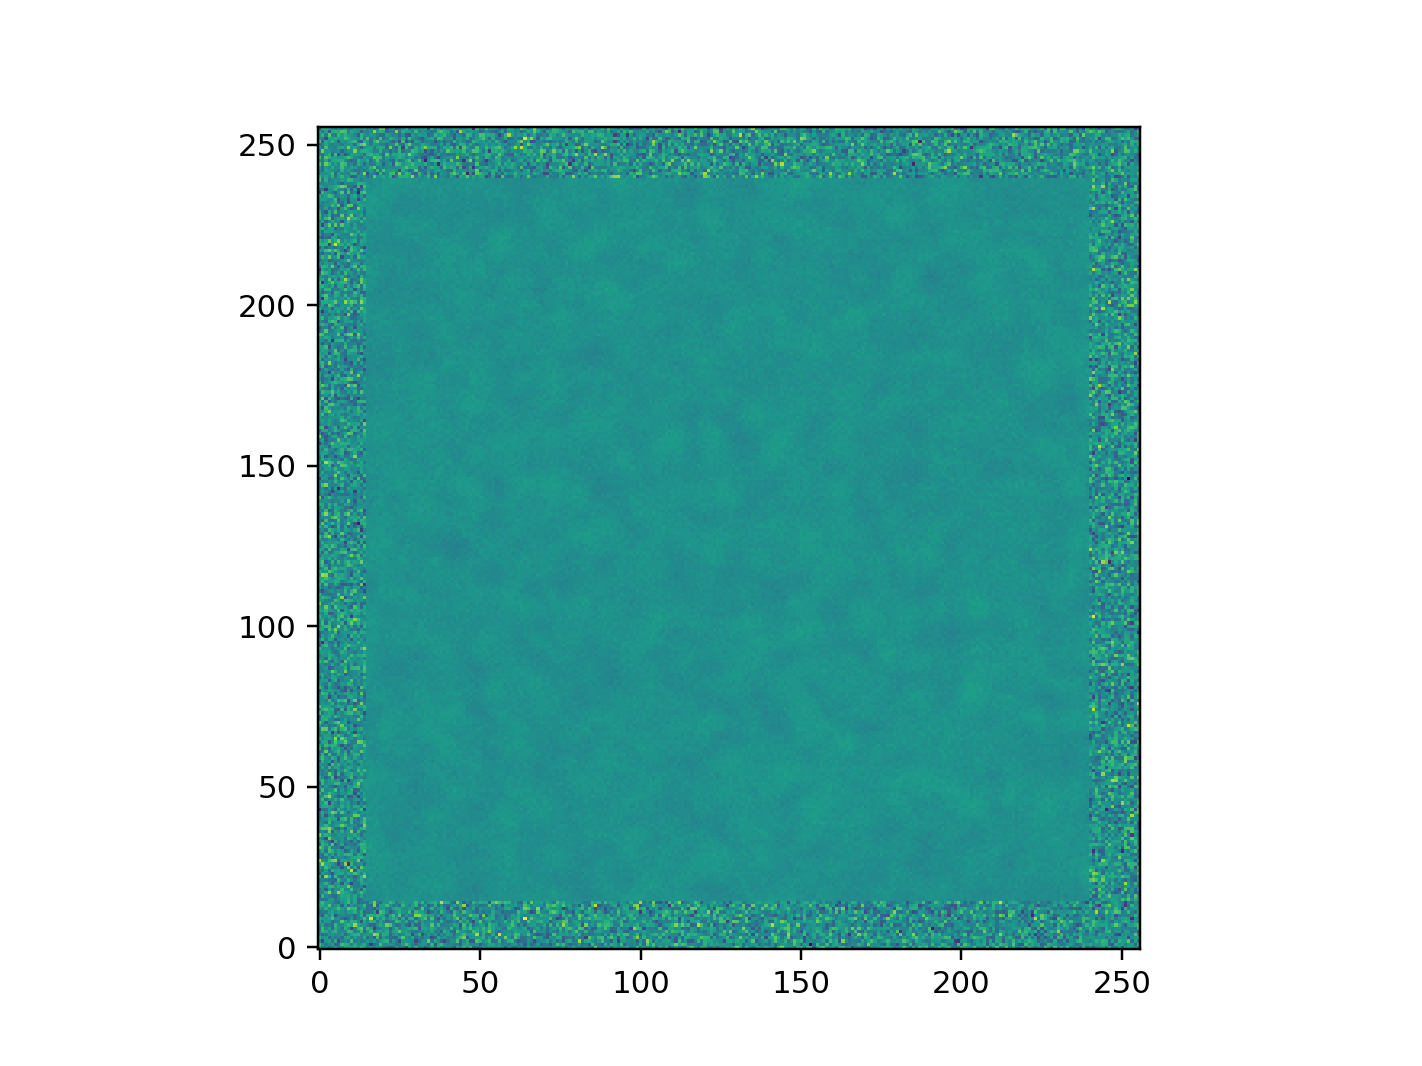

In [6]:
imD = diffExp.getImage()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(imD.getArray(), interpolation='none', origin='bottom')

# Autocorrelation in Fourier space

Calculate autocorrelation function in Fourier space. Use only the "inner" part of the image where the convolution actually happened. In this autocorrelation the image can be assumed to be periodic in all directions.

We assume that the image does not have any signal and has a mean of zero, so it's square is a noise variance sample at each pixel. We normalize each pixel by the whole image mean; then by the number of pixels to have 1 at zero distance.

In [7]:
def getAutoCorrelation(B):
    # Don't use the edge that was not convolved. 
    # It introduces structure into the autocorrelation function.
    B = B[16:240, 16:240]
    S = B/np.sqrt(np.mean(B*B))
    SF = np.fft.fft2(S)
    AC = np.real(np.fft.ifft2(SF*np.conj(SF)))
    return AC/(AC.shape[0]*AC.shape[1])

<IPython.core.display.Javascript object>


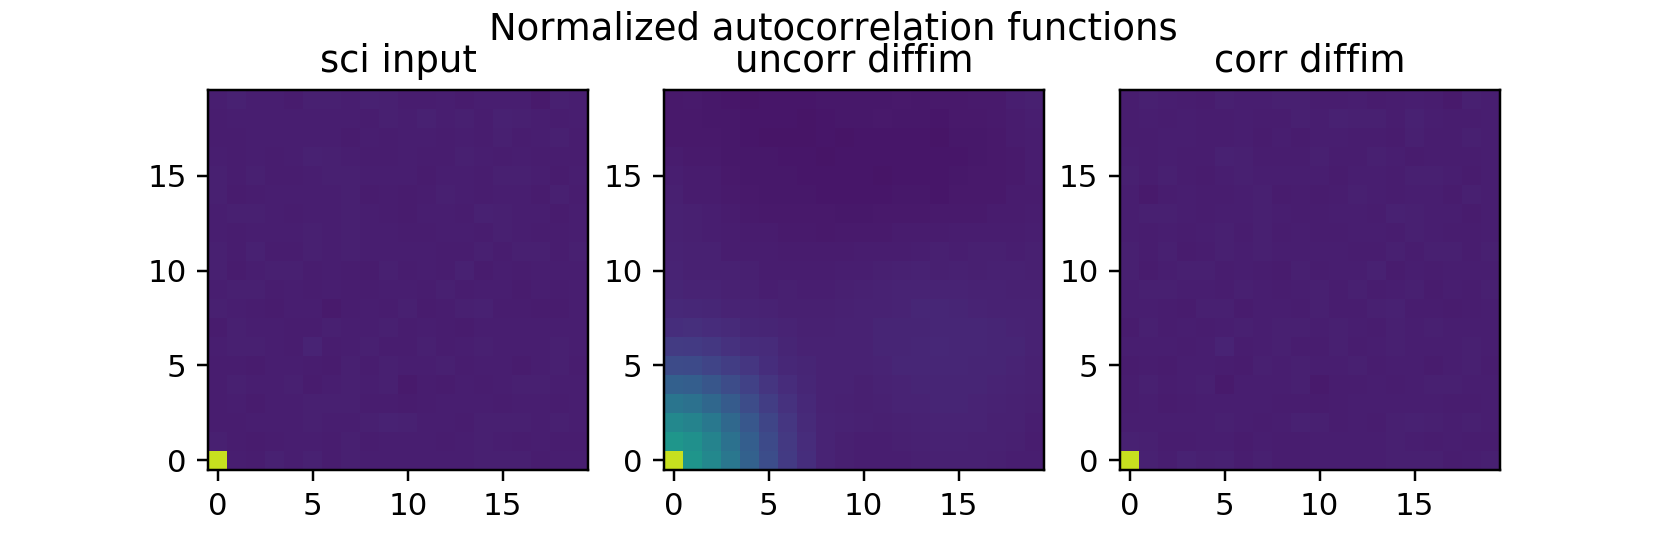

Text(0.5, 0.98, 'Normalized autocorrelation functions')

In [8]:
ac1 = getAutoCorrelation(T.im1ex.getImage().getArray())
ac2 = getAutoCorrelation(diffExp.getImage().getArray())
ac3 = getAutoCorrelation(corrected_diffExp.getImage().getArray())

fig = plt.figure(figsize=(7.5, 2.5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(ac1[:20, :20], interpolation='none', origin='bottom', vmin=-0.1, vmax=1.1)
ax.set_title('sci input')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(ac2[:20, :20], interpolation='none', origin='bottom', vmin=-0.1, vmax=1.1)
ax.set_title('uncorr diffim')

ax = fig.add_subplot(1, 3, 3)
ax.imshow(ac3[:20, :20], interpolation='none', origin='bottom', vmin=-0.1, vmax=1.1)
ax.set_title('corr diffim')
fig.suptitle("Normalized autocorrelation functions")

# Estimate the correlation directly in the image

We estimate the correlation on pixel pairs as a function of the distance between the two component pixels.

In [15]:
def estimatePixelCorrelation(B, nDist=40, convEdge=17):
    """Estimate correlation as a function of pixel distance in the image
    by sampling pixel pairs.

    Parameters
    ----------
    B : `numpy.ndarray` of 256x256 `float` elements
        Noise only image with zero pixel expectation value and identical variance
        in all pixels. Must have equal dimensions.
    nDist : `int`, optional
        Estimated distances goes from 0 to nDist-1.
        nDist must be smaller than the half dimensions of B.
    convEdge : `int`, optional
        Edge width where convolution did not happen.

    Returns
    -------
    S : `numpy.ndarray` of nDist `float` elements
        Correlation from 0 to nDist-1 pix distance. Pixels are normed by their
        variance estimation. S[0], the autocorrelation, should be close to 1.
    """
    S = np.zeros(nDist, dtype=float)
    nSample = 10000
    # Cannot use nDist wide edge, otherwise 2nd pixel can go off the image.
    # Don't bother with it.
    A = B/np.sqrt(np.mean(B[convEdge:-convEdge, convEdge:-convEdge] *
                          B[convEdge:-convEdge, convEdge:-convEdge]))
    lEdge = nDist + convEdge
    rEdge = B.shape[0] - lEdge
    for r in range(nDist):
        ind1 = np.random.randint(lEdge, rEdge, (2, nSample))
        ind2 = np.copy(ind1)
        # generate delta x,y in random directions uniformly
        c_dxy = np.exp(2.j*np.pi*np.random.random(nSample))
        ind2[0] += np.around(np.real(c_dxy)*r).astype(int)
        ind2[1] += np.around(np.imag(c_dxy)*r).astype(int)
        S[r] = np.sum(A[ind1[0], ind1[1]] * A[ind2[0], ind2[1]])/nSample
    return S

In [16]:
S1 = estimatePixelCorrelation(T.im1ex.getImage().getArray())
S2 = estimatePixelCorrelation(diffExp.getImage().getArray())
S3 = estimatePixelCorrelation(corrected_diffExp.getImage().getArray())

<IPython.core.display.Javascript object>


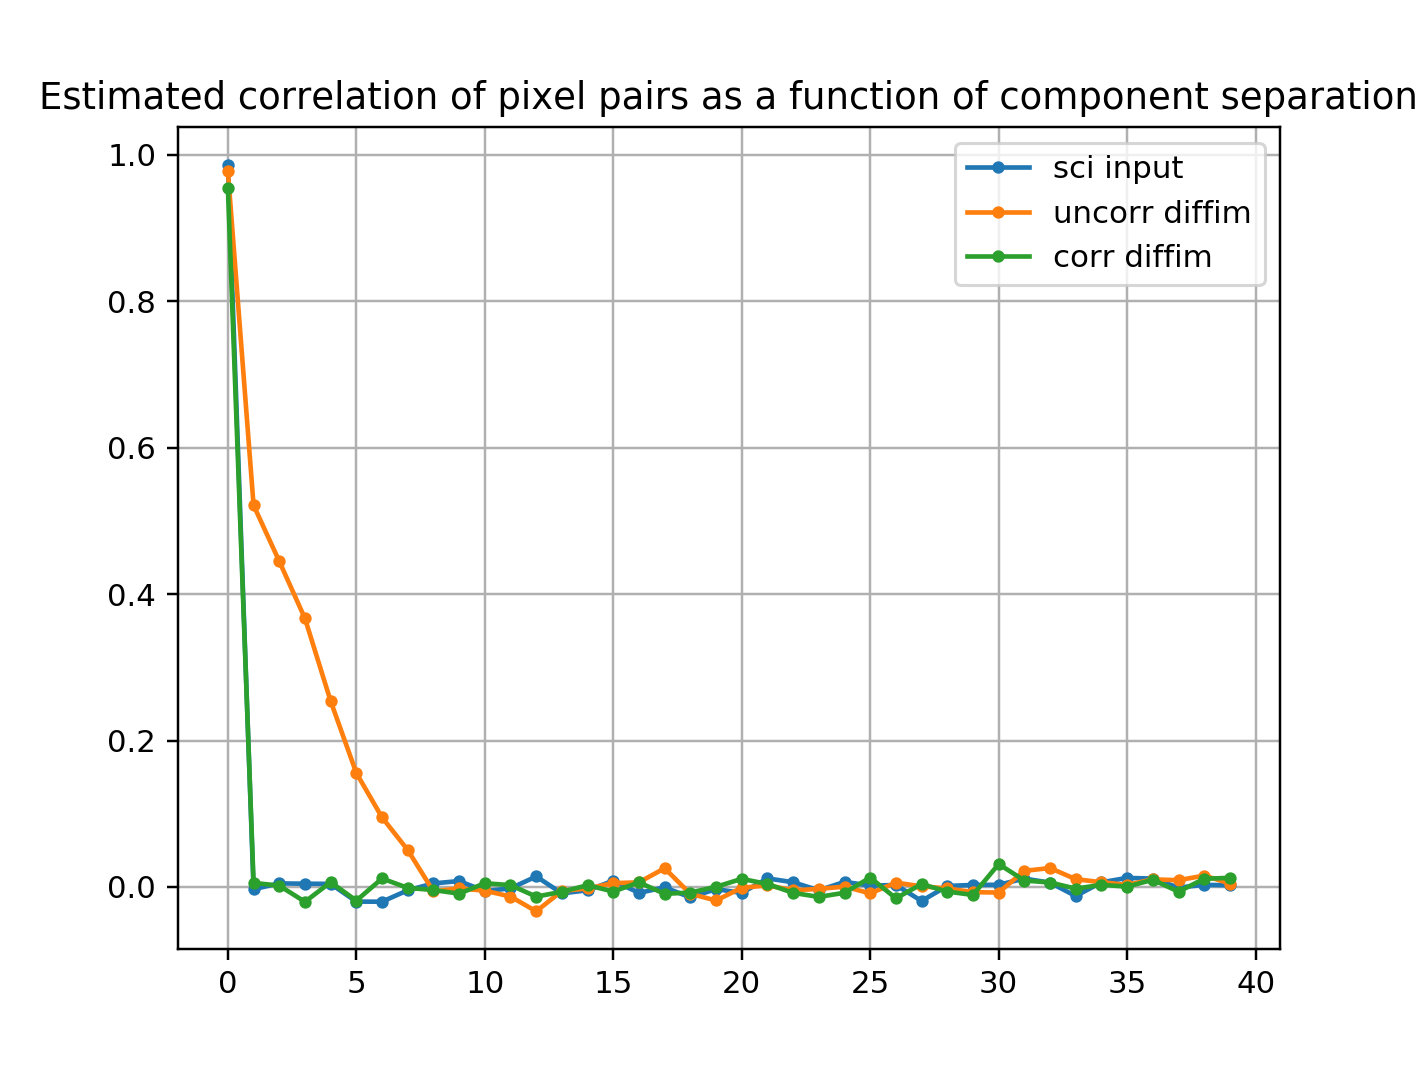

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(S1, '.-', label='sci input')
ax.plot(S2, '.-', label='uncorr diffim')
ax.plot(S3, '.-', label='corr diffim')
ax.legend()
ax.set_title('Estimated correlation of pixel pairs as a function of component separation')
ax.grid(True)

## The limits that is verified in the unit test:
- The 0th element (the autocorrelation) should be close to 1.
- The uncorrected diffim should be correlated, its 1,2,3rd elements are greater than 0.2
- The corrected diffim should not be correlated, all elements from the 1st should be close to 0.